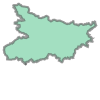

In [1]:
import geopandas as gpd
from shapely import Point
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import xarray as xr
import torch

gdf = gpd.read_file("/home/patel_zeel/compass24/data_files/polbnda_ind.shp")
bihar = gdf[gdf['nam'] == 'BIHAR']
bihar = bihar.unary_union
bihar

In [2]:
dinov2_vits14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_vits14_reg

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/patel_zeel/.cache/torch/hub/main.zip
/home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /home/patel_zeel/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 52.7MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [43]:
min_lon, min_lat, max_lon, max_lat = bihar.bounds

In [54]:
# Get shapefile and unary union of Bihar (unary union is used to merge all the polygons into one)
gdf = gpd.read_file("/home/patel_zeel/compass24/data_files/polbnda_ind.shp")
bihar = gdf[gdf['nam'] == 'BIHAR']
bihar = bihar.unary_union

# Get the bounds of Bihar
min_lon, min_lat, max_lon, max_lat = bihar.bounds

# Get data for rectangular region containing Bihar
df = xr.open_dataset("../data_files/landscan-global-2022.nc").sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))['Band1'].to_dataframe().reset_index()

# Filter out the points that are not in Bihar
df['in_bihar'] = Parallel(42)([delayed(lambda lon, lat: True if Point(lon, lat).within(bihar) else False)(lon, lat) for lon, lat in tqdm(zip(df['lon'], df['lat']))])

# Get population of Bihar
print(df[df['in_bihar']]['Band1'].sum())

0it [00:00, ?it/s]

124833302.0


In [2]:
import torch
from torchvision.transforms.functional import to_tensor

import datasets as ds
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

dataset = ds.load_dataset("Zeel/bk_haryana", streaming=True, split="train", trust_remote_code=True)

def custom_collate(batch):
    # Get the data and labels from the batch
    data = [item["image"] for item in batch]
    names = [item["name"] for item in batch]
    
    # Convert PIL images to tensors
    data = [to_tensor(item) for item in data]
    
    # Stack tensors if they have the same shape
    if all(data[0].shape == item.shape for item in data):
        data = torch.stack(data)
    else:
        # Handle case where tensors have different shapes (e.g., if they're of different sizes)
        # Here, you may need to pad or resize tensors to have the same shape
        pass
    
    # image transform
    data = data / 255.0
    
    return data, names

batch_size = 64
num_workers = 6

# collate as torch tensors
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=custom_collate)

n_loaded = 0
pbar = tqdm(dataloader)
for batch in pbar:
    data, names = batch
    print(data.shape)
    print(len(names))
    print(names[0])
    n_loaded += len(names)
    pbar.update(len(names))

0it [00:00, ?it/s]

torch.Size([64, 3, 1120, 1120])
64
27.66,76.91
torch.Size([64, 3, 1120, 1120])
64
28.49,76.13
torch.Size([64, 3, 1120, 1120])
64
29.04,76.36
torch.Size([64, 3, 1120, 1120])
64
29.44,77.01
torch.Size([64, 3, 1120, 1120])
64
29.78,77.00
torch.Size([25, 3, 1120, 1120])
25
30.88,76.90
torch.Size([64, 3, 1120, 1120])
64
27.73,76.99
torch.Size([64, 3, 1120, 1120])
64
28.49,76.77
torch.Size([64, 3, 1120, 1120])
64
29.04,77.00
torch.Size([64, 3, 1120, 1120])
64
29.45,75.04
torch.Size([64, 3, 1120, 1120])
64
29.79,74.97
torch.Size([64, 3, 1120, 1120])
64
27.77,77.04
torch.Size([64, 3, 1120, 1120])
64
28.50,75.91
torch.Size([64, 3, 1120, 1120])
64
29.05,75.91
torch.Size([64, 3, 1120, 1120])
64
29.45,75.68
torch.Size([64, 3, 1120, 1120])
64
29.79,76.36
torch.Size([64, 3, 1120, 1120])
64
27.81,76.92
torch.Size([64, 3, 1120, 1120])
64
28.50,76.55
torch.Size([64, 3, 1120, 1120])
64
29.05,76.55
torch.Size([64, 3, 1120, 1120])
64
29.45,76.32
torch.Size([64, 3, 1120, 1120])
64
29.79,77.00
torch.Size([6

KeyboardInterrupt: 

In [ ]:
dataset.n_shards

6

In [ ]:
b = 64
loader = DataLoader(dataset, batch_size=b, num_workers=6, collate_fn=lambda x: x)
n_images = 0
for i in tqdm(loader):
    n_images += b
    print(f"number of images: {n_images}")

NameError: name 'tqdm' is not defined

In [1]:
from jinja2 import Template

In [7]:
template = """
We thank the reviewers for their constructive and actionable feedback. We'd like to mention that our paper focuses more on the deployability, potentially falling within *Data and Benchmarking for Data Science Application Domains (including curation validation and release of large-scale data, experiments, performance benchmarking)* area mentioned by KDD ADS 2024. We agree that our experiments could have been more extensive, followed by more insights. However, we did not aim to optimize for novelty in this work. We'd like to highlight more insights from our work as we scaled our methodology over the Indo-Gangetic Plain:

1. We have detected and hand-verified **{{ n_brick_kilns }} brick kilns from {{ n_states }} states** in the Indo-Gangetic plain. We'll release their exact locations to accelerate research in this direction.
1. We found that **> {{ percent_pop_within }}% population lives within 800 m of the brick kilns**.
1. During the compliance studies, we found the following policy violations:
  - > *{{ percent_1_km_violation }}% of the total brick kilns are within 1 km of another kiln/kilns.
  - > *{{ percent_hosp_violation }}% of the total brick kilns are within 800 m of a hospital.
  - > *{{ percent_river_violation }}% of the total brick kilns are within 800 m of a river body.
"""

t = Template(template)
print(t.render(n_brick_kilns=1000, n_states=5, percent_pop_within=10, percent_1_km_violation=20, percent_hosp_violation=30, percent_river_violation=40))


We thank the reviewers for their constructive and actionable feedback. We'd like to mention that our paper focuses more on the deployability, potentially falling within *Data and Benchmarking for Data Science Application Domains (including curation validation and release of large-scale data, experiments, performance benchmarking)* area mentioned by KDD ADS 2024. We agree that our experiments could have been more extensive, followed by more insights. However, we did not aim to optimize for novelty in this work. We'd like to highlight more insights from our work as we scaled our methodology over the Indo-Gangetic Plain:

1. We have detected and hand-verified **1000 brick kilns from 5 states** in the Indo-Gangetic plain. We'll release their exact locations to accelerate research in this direction.
1. We found that **> 10% population lives within 800 m of the brick kilns**.
1. During the compliance studies, we found the following policy violations:
  - > *20% of the total brick kilns are 